# Using the msl_mhm library within Jupyter

OK, Galerkin was nice. But is there something even nicer? Sure, and it's the MHM method! Let's redo our simulation of a diffusion process:

\begin{equation*}
\left\lbrace
\begin{aligned}
-\nabla\cdot(\kappa \nabla u) & = f \text{ in }\,\Omega\,,\\
u & = 0 \text{ on } \partial\Omega  
\end{aligned}
\right. 
\end{equation*}

but using the MHM method instead. 

**Mind that, for the code below to work smoothly, the directories `results_convergence_l` must exist in the root of this Jupyter notebook!**

In [1]:
import os

path = "results_convergence_l"
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Successfully created the directory results_convergence_l 


Now, we're ready to proceed to C++. As always, you first need to setup the location of the include and library files:

In [1]:
#pragma cling add_library_path("/usr/local/lib/")

#pragma cling add_include_path("/usr/local/include")
#pragma cling add_include_path("/usr/local/include/msl_core")
#pragma cling add_include_path("/usr/local/include/msl_core/third_party")
#pragma cling add_include_path("/usr/local/include/msl_cg")
#pragma cling add_include_path("/usr/local/include/msl_mhm")

#pragma cling load("libeasyloggingpp.so")
#pragma cling load("libtriangle.so")
#pragma cling load("libtetgen.so")
#pragma cling load("libmsl_core.so")
#pragma cling load("libmsl_cg.so")
#pragma cling load("libmsl_mhm.so")

#pragma cling load("libomp.so")


After that, just `#include` the relevant header files and throw your code!



In [2]:
#include <memory>
#include <string>
#include <valarray>
#include <vector>
#include <fstream>
#include <chrono>
#include <omp.h>

#include "Easylogging++/include/easylogging++.h"

//Yeah, it's cpp indeed, to avoid compiling this module separatedly out of the notebook
#include "problem_cgdiffusion.cpp"

#include "problem_mhmcgdecorator.h"

#include "Facade/problem_mhmglobal.h"
#include "Facade/problem_mhmlocal.h"
#include "Utils/utils.h"

In [3]:
MSL_configure_easyloggingpp();

In [4]:
{
    omp_set_num_threads(2);
    
    std::ofstream conv_data_mhm;
    conv_data_mhm.open("conv_data_mhm_l.txt");
    
    for (int l=0; l<4; ++l)
    {
        //! [Building config files]
        std::string path_conf = "results_convergence_l/config_mhm_jupyterMSL";
        std::ofstream ofile;
        ofile.open(path_conf);
        ofile 
            << "./test_data ccross 3" << std::endl
            << "./test_data 1 physics_diffusion_2d_with_u" << std::endl
            << "./results_convergence_l/tree_jupyterMSL_" << l << std::endl
            << "./results_convergence_l 5" << std::endl
            << "     depth" << std::endl
            << "     subelems" << std::endl
            << "     subfaces" << std::endl
            << "     psi" << std::endl
            << "     phi";
        ofile.close();

        ofile.open("./results_convergence_l/depth");
        ofile << "0" << std::endl;
        ofile << "1";
        ofile.close();

        ofile.open("./results_convergence_l/subelems");
        ofile << "0" << std::endl;
        ofile << "1";
        ofile.close();

        ofile.open("./results_convergence_l/subfaces");
        ofile << "0" << std::endl;
        ofile << "0";
        ofile.close();

        ofile.open("./results_convergence_l/psi");
        ofile << "0" << std::endl;
        ofile << l;
        ofile.close();

        ofile.open("./results_convergence_l/phi");
        ofile << "0" << std::endl;
        ofile << l+2;
        ofile.close();
        //! [Building config files]

        //! [Configuring global problem]
        std::string splitlog;
        std::vector<std::string> branches;

        MHMGlobalProblem<DiffusionCGProblem, CGMHMDecorator<DiffusionCGProblem>> P0;
        P0.readDataFiles({path_conf});

        if (l==0) {//print only on first step because these params and data don't change
            P0.printParams();
            P0.printData();
        }
        
        LOG(INFO) << "=== l " << l;

        splitlog = P0.splitToDisk(branches);
        //! [Configuring global problem]

        const auto before = std::chrono::system_clock::now();

        //! [Configuring and solving local problems]
        std::vector<
            MHMLocalProblem<DiffusionCGProblem, CGMHMDecorator<DiffusionCGProblem>>
        >
        SPs(branches.size());

        #pragma omp parallel for
        for (int L=0; L<branches.size(); ++L) {
            std::vector<LocalContrib*> contrib_LHSs(P0.getLHS()->getNumContribSets());
            std::vector<LocalContrib*> contrib_RHSs(P0.getRHS()->getNumContribSets());
            for (int i=0; i<contrib_LHSs.size(); ++i)
                contrib_LHSs[i] = &(P0.getLHS()->getContribSet(i)[L]);
            for (int i=0; i<contrib_RHSs.size(); ++i)
                contrib_RHSs[i] = &(P0.getRHS()->getContribSet(i)[L]);

            SPs[L].setPathData(branches[L]);
            SPs[L].readDataFiles({"config_mhm"});

            SPs[L].configureSpaces();
            SPs[L].buildVariationalForm();

            SPs[L].solve(contrib_LHSs, contrib_RHSs);

            SPs[L].printMeshWithHeaders(branches[L], "micromesh");
        }
        //! [Configuring and solving local problems]
        
        const auto local_problems = std::chrono::system_clock::now();
        const std::chrono::duration<double, std::milli> duration_lp = local_problems - before;


        //! [Solving global problem]
        LocalContribSet unmount_sol;
        P0.solve(unmount_sol);
        //! [Solving global problem]

        const auto global_problem = std::chrono::system_clock::now();
        const std::chrono::duration<double, std::milli> duration_gp = global_problem - local_problems;

        //! [Computing solution and approximation error]
        std::valarray<MSL_FP_TYPE> local_errorsL2(0.0, branches.size());
        std::valarray<MSL_FP_TYPE> local_errorsH1(0.0, branches.size());
        std::valarray<MSL_FP_TYPE> local_errorsL2_dual(0.0, branches.size());
        std::valarray<MSL_FP_TYPE> local_errorsHdiv_dual(0.0, branches.size());

        #pragma omp parallel for
        for (int L=0; L<branches.size(); ++L) {
            std::vector<LocalContrib*> sol_contribs(unmount_sol.getNumContribSets());
            for (int i=0; i<sol_contribs.size(); ++i)
                sol_contribs[i] = &(unmount_sol.getContribSet(i)[L]);

            SPs[L].computeSolution(sol_contribs);
            SPs[L].appendResultsToMesh();

            local_errorsL2[L] = pow(SPs[L].computeError("L2"), 2);
            local_errorsH1[L] = local_errorsL2[L] + pow(SPs[L].computeError("semiH1"), 2);
        }

        MSL_FP_TYPE global_sum_errorsL2 = local_errorsL2.sum();
        MSL_FP_TYPE global_sum_errorsH1 = local_errorsH1.sum();

        global_sum_errorsL2 = sqrt(global_sum_errorsL2);
        global_sum_errorsH1 = sqrt(global_sum_errorsH1);

        const auto post_processing = std::chrono::system_clock::now();
        const std::chrono::duration<double, std::milli> duration_pp = post_processing - global_problem;

        LOG(INFO) << "    L2-norm error:   " << global_sum_errorsL2;
        LOG(INFO) << "    H1-norm error:   " << global_sum_errorsH1 << std::endl;
        //! [Computing solution and approximation error]

        const std::chrono::duration<double, std::milli> duration = std::chrono::system_clock::now() - before;
        LOG(INFO) << "    Total time:      " << duration.count() << "ms";
        LOG(INFO) << "    Local problems:  " << duration_lp.count() << "ms";
        LOG(INFO) << "    Global problem:  " << duration_gp.count() << "ms";
        LOG(INFO) << "    Post processing: " << duration_pp.count() << "ms" << std::endl;
        
        conv_data_mhm << l << " " << global_sum_errorsL2 << " " << global_sum_errorsH1 << std::endl;
    }
    
    conv_data_mhm.close();
}

2023-02-07 18:03:28,731 [INFO] ************************ PARAMETERS ********************************

Pk           => size=1; values=[2]
Lk           => size=1; values=[0]
NDivElem     => size=1; values=[1]
FacePatterns => size=1; values=[{}]

2023-02-07 18:03:28,731 [INFO] ********************** END OF PARAMETERS ***************************

2023-02-07 18:03:28,731 [INFO] **************************    DATA    ******************************

diffusion = {
    kappa = 1.0, 
    --
    f     = "8*pi*pi * math.sin(2*pi*x) * math.sin(2*pi*y)",
    --
    u     = "math.sin(2*pi*x)*math.sin(2*pi*y)",
    --
    du    = "{2*pi*math.cos(2*pi*x)*math.sin(2*pi*y),2*pi*math.sin(2*pi*x)*math.cos(2*pi*y)}",
    --
    q     = "{-2*pi*math.cos(2*pi*x)*math.sin(2*pi*y),-2*pi*math.sin(2*pi*x)*math.cos(2*pi*y)}",
    --
    f_iOrder = 4,
    u_iOrder = 4,
    du_iOrder = 4,
    q_iOrder = 4,
    --
    g = {
        ["1"] = 0,
        ["2"] = 0,
        ["3"] = 0,
        ["4"] = 0,
        ["5"] = 0  -

Let's save the data in tar file so you can easily "download" the results and visualize them in Paraview...

In [5]:
!for i in {0..3}; do ./reduce_micromeshes_to_single_mesh.sh results_convergence_l/tree_jupyterMSL_$i 0; done

mv: cannot stat '../solution.nsca*': No such file or directory

Generating MHMSolution.case
Generating MHMSolution.geo
Generating solution.nsca
mv: cannot stat '../solution.nsca*': No such file or directory

Generating MHMSolution.case
Generating MHMSolution.geo
Generating solution.nsca
mv: cannot stat '../solution.nsca*': No such file or directory

Generating MHMSolution.case
Generating MHMSolution.geo
Generating solution.nsca
mv: cannot stat '../solution.nsca*': No such file or directory

Generating MHMSolution.case
Generating MHMSolution.geo
Generating solution.nsca


In [6]:
!tar zcvf results_convergence_l.tar.gz results_convergence_l/tree_jupyterMSL_*/{MHMSolution.case,MHMSolution.geo,solution.nsca}

results_convergence_l/tree_jupyterMSL_0/MHMSolution.case
results_convergence_l/tree_jupyterMSL_1/MHMSolution.case
results_convergence_l/tree_jupyterMSL_2/MHMSolution.case
results_convergence_l/tree_jupyterMSL_3/MHMSolution.case
results_convergence_l/tree_jupyterMSL_0/MHMSolution.geo
results_convergence_l/tree_jupyterMSL_1/MHMSolution.geo
results_convergence_l/tree_jupyterMSL_2/MHMSolution.geo
results_convergence_l/tree_jupyterMSL_3/MHMSolution.geo
results_convergence_l/tree_jupyterMSL_0/solution.nsca
results_convergence_l/tree_jupyterMSL_1/solution.nsca
results_convergence_l/tree_jupyterMSL_2/solution.nsca
results_convergence_l/tree_jupyterMSL_3/solution.nsca


Let's now get back to Python and plot some convergence curves....

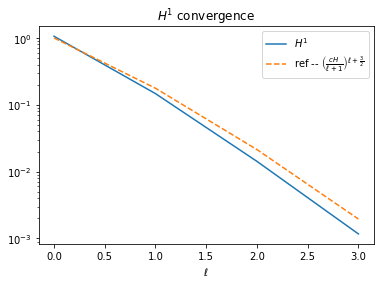

In [2]:
import matplotlib.pyplot as plt

# Load the data from the file into three arrays
l, eL2, eH1 = [], [], []
with open('conv_data_mhm_l.txt', 'r') as file:
    for line in file:
        values = line.split()
        l.append(float(values[0]))
        eL2.append(float(values[1]))
        eH1.append(float(values[2]))
        
H = 0.25
c = 4
rH1 = []
for i in range(4):
    rH1.append(pow(c*H/float(i+1), (i+1.5)))
        
plt.plot(l, eH1, label=r'$H^1$')
plt.plot(l, rH1, label=r'ref -- ${\left(\frac{cH}{\ell+1}\right)}^{\ell+\frac{3}{2}}$', linestyle="dashed")
plt.xlabel(r'$\ell$')
plt.yscale('log')
plt.title(r'$H^1$ convergence')
plt.legend()
plt.show()